In [3]:
import sys
sys.path.append('./')
from nqueens import Solver_8_queens

In [87]:
t = 'asd'
t == 'asd'

True

In [97]:
# -*- coding: utf-8 -*-
import random
import math

class Solver_8_queens:
    desk_size = 8
    point_size = 3 # num of row in binary
    ppltn_indexes = list() # temp polulation
    ppltn = list()      # current population
    p_size = 0          # ppltn size
    cross_p = 0.5       # corssingover probability
    mutation_p = 0.05   # mutation probability
    max_clashes =  28 
    selection = 'tournament' # 'ring' 
    def __init__(self, pop_size=200, cross_prob=0.7, mut_prob=0.1, selection='tournament', desk_size=8):
        self.p_size = pop_size
        self.cross_p = cross_prob
        self.mutation_p = mut_prob
        self.desk_size = desk_size
        self.point_size = int(math.log2(desk_size))
        self.max_clashes =  sum(range(desk_size))
        if selection != 'tournament' and selection != 'ring':
            raise BaseException('No valid selection type. Must be "tournament" or "ring"')
        self.selection = selection
    def solve(self, min_fitness=0.9, max_epochs=100):
        best_fit=None
        epoch_num=None
        visualization=None

        self.generate_ppltn()

        i = 0
        while i < max_epochs and max(self.get_ppltn_fitness(self.ppltn)) < min_fitness:
            self.step_one()
            i = i + 1 
        best_fit = max(self.get_ppltn_fitness(self.ppltn))
        epoch_num = i
        for cell in self.ppltn:
            if self.fitness(cell) == best_fit:
                visualization = self.to_str(cell)
                break
        return best_fit, epoch_num, visualization
    
    def cell_to_points(self, cell):
        points = list()
        for i in range(self.desk_size):
            cell_part = cell[i * self.point_size:(i + 1) * self.point_size]
            points.append((i, int(''.join(cell_part), 2)))
        return points
    
    def is_clash(self, a, b):
        return  a[0] == b[0] or a[1] == b[1] or abs((a[0]-b[0]) / (a[1]-b[1])) == 1

    def all_clashes(self, points):
        _sum = 0
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                _sum = _sum + int(self.is_clash(points[i], points[j]))
        return _sum
    
    def fitness(self, cell):
        d = self.max_clashes - self.all_clashes(self.cell_to_points(cell))
        return d / self.max_clashes
   
    def to_str(self, cell):
        res = list(('+' * self.desk_size + '\n') * self.desk_size)
        for p in self.cell_to_points(cell):
            res[p[0] * (self.desk_size + 1)+  p[1]] = 'Q'
        return ''.join(res)
    
    def generate(self):
        cell = list()
        fmt_str = '{0:0' + str(self.point_size) + 'b}'
        for i in range(self.desk_size):
            b = list(fmt_str.format(random.randrange(self.desk_size)))
            cell = cell + b
        return cell
        
    def get_ppltn_fitness(self, ppltn):
        fitness = list()
        for cell in ppltn:
            fitness.append(self.fitness(cell))
        return fitness

    def get_ppltn_probs(self, ppltn):
        probs = self.get_ppltn_fitness(ppltn)
        # normalize
        sum_p = sum(probs)
        last_p = 0
        for i in range(len(probs)):
            probs[i] = last_p + probs[i] / sum_p
            last_p = probs[i]
        return probs
        
    def ring_select(self, probs, p):
        for i in range(len(probs)):
            if p < probs[i]:
                return i
        return len(probs) - 1
        
    def one_point_crossing(self, a, b):
        k = random.randrange(len(a) / 3) * 3 
        return [a[0:k] + b[k: len(a)],b[0: k] + a[k: len(a)]]
            
    def generate_ppltn(self):
        '''generate start population'''
        self.ppltn = list()
        for i in range(self.p_size):
            self.ppltn.append(self.generate())

    def apply_mutation(self, cell):
        try:
            bit_count = random.randrange(int(len(cell) * self.mutation_p))
            for k in random.sample(range(len(cell)), bit_count):
                cell[k] = '1' if cell[k] == '0' else '0'
        except:
            pass
        return cell
    def ring_selection_step(self):
        self.ppltn_indexes = list()        
        probs = self.get_ppltn_probs(self.ppltn);
        for i in range(int(self.p_size * self.cross_p)):
            a = self.ring_select(probs, random.random())
            self.ppltn_indexes.append(a)
            
    def tournament_selection_step(self):
        self.ppltn_indexes = list()
        indexes = list(range(len(self.ppltn)))
        random.shuffle(indexes)
        mid = int(len(self.ppltn) / 2)
        g1 = indexes[0:mid]
        g2 = indexes[mid : len(self.ppltn)]  
        # don't care about odd ppltn_size
        for i in range(len(g1)):
            if (self.fitness(self.ppltn[g1[i]]) > self.fitness(self.ppltn[g2[i]])):
                self.ppltn_indexes.append(g1[i])
            else: 
                self.ppltn_indexes.append(g2[i])      
    
    def selection_step(self):
        if self.selection == 'tournament':
            self.tournament_selection_step()
        elif self.selection == 'ring':
            self.ring_selection_step()    
    
    def crossing_step(self):
        new_ppltn = list()   

        for i in range(self.p_size):
            a = random.randrange(len(self.ppltn_indexes))
            a = self.ppltn_indexes[a]
            b = random.randrange(len(self.ppltn_indexes))
            b = self.ppltn_indexes[b]
            while a == b:
                b = random.randrange(len(self.ppltn_indexes))
                b = self.ppltn_indexes[b]            
            offsprings = self.one_point_crossing(self.ppltn[a], self.ppltn[b])
            new_ppltn = new_ppltn + offsprings
        self.ppltn = new_ppltn

    def mutation_step(self):
        mutation_ppltn = list()
        for cell in self.ppltn:
            cell = self.apply_mutation(cell)
            mutation_ppltn.append(cell)
        self.ppltn = mutation_ppltn

    def step_one(self):
        self.selection_step()
        self.crossing_step()
        self.mutation_step()

In [129]:
solver = Solver_8_queens(200, 0.5, 0.1)
best_fit, epoch, visualization = solver.solve(1, 1000)
print ('Best fitness: ', best_fit)
print ('Epoch: ', epoch)
print (visualization)

Best fitness:  1.0
Epoch:  40
+++Q++++
+++++Q++
+++++++Q
+Q++++++
++++++Q+
Q+++++++
++Q+++++
++++Q+++



In [100]:
import numpy as np
import matplotlib.pyplot as plt

p_size = np.linspace(50, 1000, 20)
cross_p = np.linspace(0.05, 1, 20)
iter_count = np.ndarray(shape=(p_size.shape[0], cross_p.shape[0]), dtype=np.float32)
max_epoch = 100
for i in range(p_size.shape[0]):
    for j in range(cross_p.shape[0]):
        solver = Solver_8_queens(int(p_size[i]), cross_p[j], 0.1)
        best_fit, epoch, visual = solver.solve(1, max_epoch)
        iter_count[i][j] = epoch

KeyboardInterrupt: 

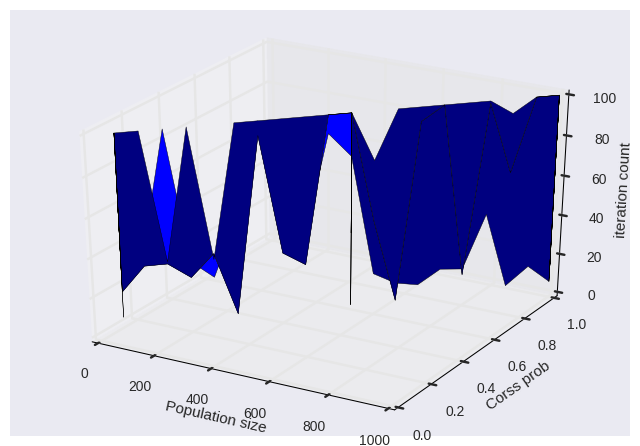

In [38]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis
# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.
p_size, cross_p = np
surf = ax.plot_surface(p_size, cross_p, iter_count)
ax.set_xlabel('Population size')
ax.set_ylabel('Corss prob')
ax.set_zlabel('iteration count')
plt.show()

In [39]:
iter_count.tofile('iter_count01.bin')

In [35]:
b = np.fromfile('iter_count.bin')

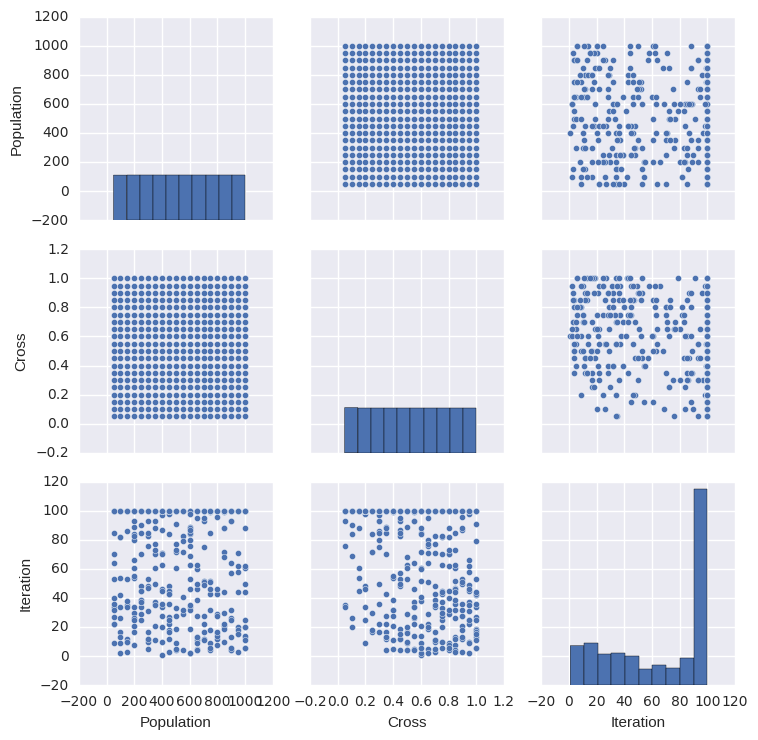

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sbs
%matplotlib inline
p_size = np.linspace(50, 1000, 20)
cross_p = np.linspace(0.05, 1, 20)
X, Y = np.meshgrid(p_size, cross_p)
iter_count = np.fromfile('iter_count.bin', dtype=np.float32)
iter_count1 = np.fromfile('iter_count01.bin', dtype=np.float32)
Z = np.reshape(iter_count1, newshape=X.shape)
frame = pd.DataFrame()
frame['Population'] = np.reshape(X, 400)
frame['Cross'] = np.reshape(Y, 400)
frame['Iteration'] = np.reshape(Z, 400)
sbs.pairplot(frame)

## 